In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import kagglehub
import os
import torch.functional as F
import torch.nn as nn
import seaborn as sns
from torch import optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Dataset_Preparation and Sampling

In [2]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
image_size = 16
hidden_nodes = 128

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)
print("Total images:", len(dataset))
print("Classes:", dataset.classes)

Using Colab cache for faster access to the 'flowers-recognition' dataset.
Total images: 4317
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [3]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, shuffle=True)
val_dataset = DataLoader(val_data, shuffle=True)

# Training start

In [6]:
# Create a model Class that inherits nn.module to make a simple neural network
class model(nn.Module):
  # Input layer (224*3) inputs ---> Hidden layer 1 (128) --> Output Layer (5) --> Softmax(Output)
  def __init__(self, in_feature = image_size*image_size*3, hidden_layer_1 = hidden_nodes, out_features = 5):
    super().__init__()    # Instantiate our nn.module class
    self.fc1 = nn.Linear(in_feature, hidden_layer_1)
    self.out = nn.Linear(hidden_layer_1, out_features)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.out(x)
    return x

## L1 Regularization

In [7]:
torch.manual_seed(41)
Model = model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr = learning_rate)
loss_values=[]
training_accuracy = []
validation_accuracy = []
Model.train()

for epoch in range(num_epochs):
    running_loss = 0.0  # Reset for each epoch

    for images, labels in train_dataset:
        # 1. Forward pass
        outputs = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        loss = criterion(outputs, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 3. ACCUMULATE LOSS (Crucial Step)
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_dataset)
    loss_values.append(avg_loss)

    # Evaluation of the model on every epoch on validation data
    pred_actual_pairs_val = []
    with torch.no_grad():
      for images, label in val_dataset:
        y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        for i in range(len(y_eval)):
          pred_actual_pairs_val.append((torch.argmax(y_eval[i]).item(), int(label[i])))
    y_pred = np.array([p for p, a in pred_actual_pairs_val])
    y_true = np.array([a for p, a in pred_actual_pairs_val])
    validation_accuracy_instance = (y_pred == y_true).mean()
    validation_accuracy.append(validation_accuracy_instance)

    # Evaluation of the model on every epoch on training data
    pred_actual_pairs_train = []
    with torch.no_grad():
      for images, label in train_dataset:
        y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        for i in range(len(y_eval)):
          pred_actual_pairs_train.append((torch.argmax(y_eval[i]).item(), int(label[i])))
    y_pred = np.array([p for p, a in pred_actual_pairs_train])
    y_true = np.array([a for p, a in pred_actual_pairs_train])
    training_accuracy_instance = (y_pred == y_true).mean()
    training_accuracy.append(training_accuracy_instance)

    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 1.4108177688386705
Epoch 2, Loss: 1.2590050758035094
Epoch 3, Loss: 1.2231378113781963
Epoch 4, Loss: 1.166900802541662
Epoch 5, Loss: 1.155154432963442
Epoch 6, Loss: 1.1161082574614771
Epoch 7, Loss: 1.1123254994551341
Epoch 8, Loss: 1.0892288756591302
Epoch 9, Loss: 1.0781282274811357
Epoch 10, Loss: 1.0477021822222956


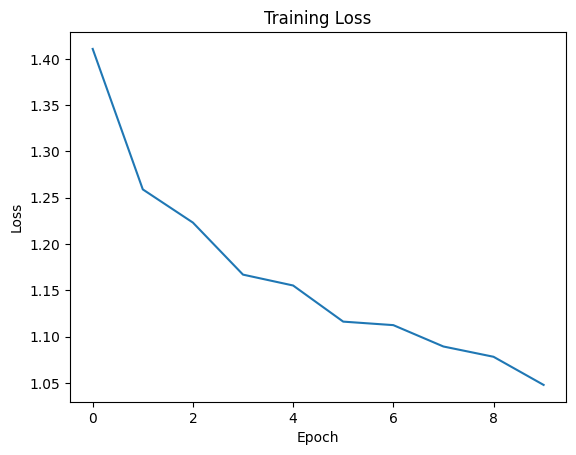

In [8]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

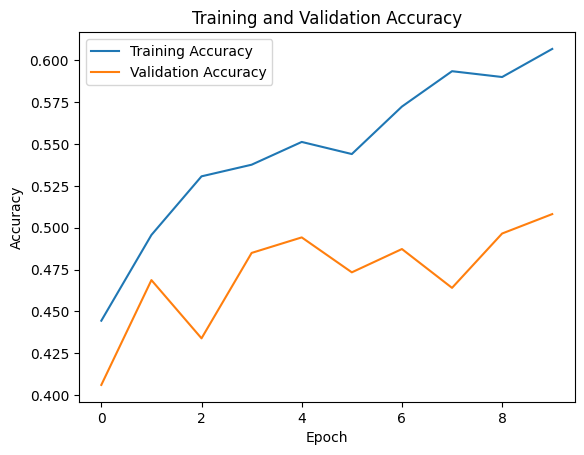

In [9]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [10]:
pred_actual_pairs = []
with torch.no_grad():
  for images, label in test_dataset:
    y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
    pred_actual_pairs.append({torch.argmax(y_eval), int(label)})
y_pred = np.array([p for p, a in pred_actual_pairs])
y_true = np.array([a for p, a in pred_actual_pairs])

accuracy = (y_pred == y_true).mean()
print(f"Overall Accuracy: {accuracy:.4f}")

Overall Accuracy: 0.4907


Almost similar to regularization and it is not overfitting as well